In [1]:
import sys, os

import numpy as np

from html.parser import HTMLParser
from tqdm import tqdm_notebook as tqdm

import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import timedelta

import yfinance as yf
from yahoofinancials import YahooFinancials

from humpack import tdict, Key_Table, Table

from tabulate import tabulate

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import torch
from foundation import util

import selections as SEL
import organization as ORG
import strategy as SRG

In [2]:
def run_tk(data=None, max_hist=3*365, itrs=100, interval=100, overlap=True, tk=None,
          start=None, end=None):

    if data is None:
        data = get_data(tk, max_hist)

    max_hist = len(data)

    if start is None or end is None:
    
        start, end = ORG.sample_time(itrs, interval=interval, max_hist=max_hist, overlap=overlap)

    out = data[end] - data[start]
    return out

def get_data(tk, hist=3*365):
    tk = yf.Ticker(tk)
    data = tk.history(start=datetime.today() - timedelta(days=hist)).to_numpy()[:, 3]
    data /= data[0]
    data -= 1
    data *= 100
    return data

In [3]:
yd = 365

start = yd*5
interval = 50
itrs = 1000


In [4]:
groups = SRG.strategy
comp = {}
for entries in groups.values():
    comp.update(entries)
len(comp)

54

In [5]:
full = {}
T = Table()
for g, group in SRG.strategy.items():
    for n, w in group.items():
        full[n] = tdict(t=n, w=w, g=g)
        T.new(t=n, w=w, g=g)
len(full), len(T)

(54, 54)

In [6]:
sum(s.w for s in T)

1.0000000000000007

In [7]:
etfs = {etf:tdict(**val) for etf, val in SRG.etfs.items()}
funds = {funds:tdict(**val) for funds, val in SRG.funds.items()}
stocks = {stocks:tdict(**val) for stocks, val in SRG.stocks.items()}

In [8]:
x = T[0]
x

t{'t':'MSFT', 'w':0.03, 'g':'companies'}

In [9]:
companies = {}
for x in T:
    if x.t in etfs:
        contents = etfs[x.t].holdings.items()
    else:
        contents = [(x.t, 100.)]
    for c, cw in contents:
        if c not in companies:
            companies[c] = 0.
        companies[c] += cw * x.w / 100
len(companies)

431

In [10]:
ratios = [(c,w*100) for c,w in 
               sorted(companies.items(), key=lambda x: x[1], reverse=True)]
print(tabulate(ratios, headers=('Company', '%')))

Company          %
---------  -------
IAU        5
MSFT       3.5813
0700.HK    3.5336
AMZN       3.4417
BABA       3.3739
TSLA       3.2245
FUAMX      2.5
NVDA       2.24885
AMD        2.09945
VGLT       2
SCHO       2
VCLT       2
BIDU       1.2109
GOOG       1.1674
PYPL       1.0345
NTDOY      1
FIPDX      1
IGOV       1
AGG        1
VCSH       1
LQD        1
IAGG       1
FB         0.8174
NFLX       0.5569
DIS        0.5426
AAPL       0.5142
SNE        0.5
MINT       0.5
600519.SS  0.42625
INDA       0.4182
601318.SS  0.32475
3690.HK    0.3123
005930.KS  0.2873
JD         0.2598
2330.TW    0.2529
GOOGL      0.2491
NTES       0.24905
AMGN       0.2086
BILI       0.20835
CSCO       0.19855
PDD        0.1884
600036.SS  0.18365
ENPH       0.1764
000858.SZ  0.17635
UNH        0.1763
VRTX       0.1758
GILD       0.173
JNJ        0.1651
FSLR       0.1587
600276.SS  0.1543
NSRGF      0.15265
ORA        0.1506
CRWD       0.14305
REGN       0.1416
SPLK       0.13675
TAL        0.1326
TOYOF  

In [11]:
for x in tqdm(T):
    x.data = get_data(x.t)

C:\Users\anwan\anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [12]:
tks = np.array(list(T.select('t')))

In [13]:
w = np.array(list(T.select('w')))
w.sum(), w.shape

(1.0, (54,))

In [14]:
span = min(map(len,T.select('data')))
span

442

In [15]:
close = np.stack(d[-span:] for d in T.select('data'))
close.shape

C:\Users\anwan\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


(54, 442)

In [16]:
out = close[:,-1] - close[:,0]
order = np.argsort(out)[::-1]
print(tabulate(np.stack([tks,out],1)[order], headers=('Company', '%')))

Company              %
---------  -----------
TSLA       378.541
AMD        209.746
PYPL       163.008
MSFT       143.537
AMZN       125.758
NVDA       104.198
ACES        90.7498
XITK        89.5668
0700.HK     84.0915
ESPO        78.772
ICLN        75.0588
BABA        71.8968
NFLX        66.7341
SKYY        60.5541
SOCL        55.2553
KWEB        52.572
SNE         49.6248
FB          49.5964
CNYA        49.345
VONG        49.2518
IAU         48.5927
VGLT        48.5742
GOOG        45.1609
ASHR        43.2869
CIBR        42.4779
VCLT        37.793
MCHI        36.4565
PHO         34.9446
NTDOY       32.1986
LQD         28.6703
IBB         25.9895
FHLC        22.9693
FUAMX       21.6535
AGG         19.2642
FZROX       18.0244
FIPDX       16.7387
IAGG        14.2231
VCSH        11.9006
FSMAX       11.3493
IGOV         9.80433
SCHO         8.08039
EWG          7.41902
FSGGX        6.65543
VGK          6.38797
FSPSX        4.77573
MINT         4.63576
DIS          3.67141
FIDU         2.2

In [17]:
w @ out

56.08895011826625

In [18]:
from scipy import interpolate

In [19]:
# start, end = ORG.sample_time(1000, interval=30, max_hist=span, overlap=True)

In [20]:
intv = 50

In [21]:
def get_intv(intv, resample=False):
    diff = close[:,intv:] - close[:,:-intv]
    ret = w @ diff
    
    if resample:
        x = np.linspace(0,1,span-intv)
        rsample = interpolate.interp1d(x, ret, kind = 'cubic')
        rsample = interpolate.UnivariateSpline(x, ret)
        return rsample(np.linspace(0,1,span))
    
    return ret

<IPython.core.display.Javascript object>


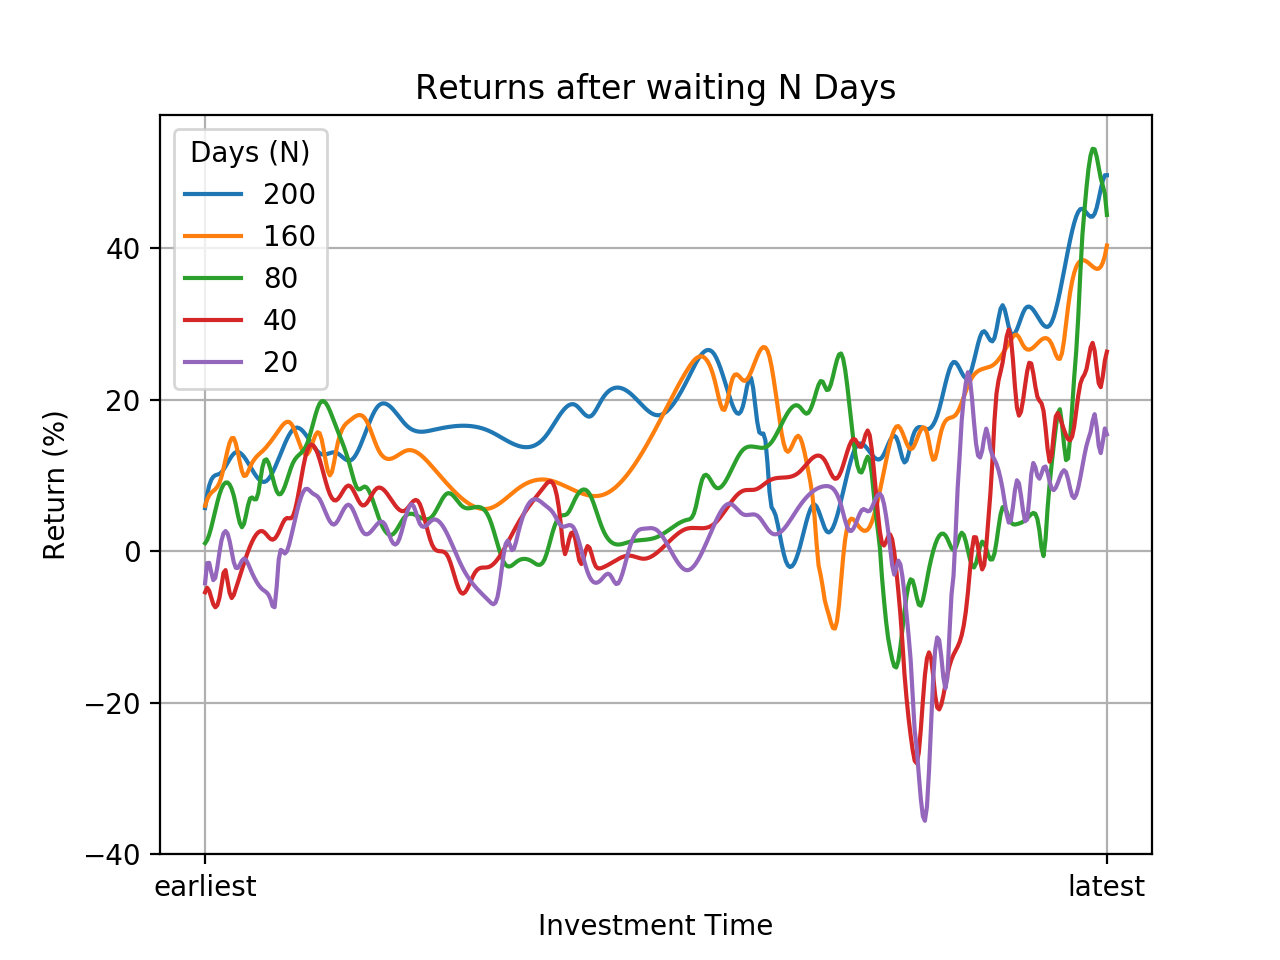

In [22]:
sintvs = [200, 160, 80, 40, 20]
plt.figure()
for intv in  sintvs:
    plt.plot(np.linspace(0,1,span), get_intv(intv, resample=True), label=str(intv))
plt.xticks([0,1], ['earliest', 'latest'])
plt.legend(title='Days (N)')
plt.xlabel('Investment Time')
plt.ylabel('Return (%)')
plt.title('Returns after waiting N Days')
ax = plt.gca()
ax.set_axisbelow(True)
plt.grid(zorder=0)
pass

In [23]:
# plt.savefig('figures/short.png')

<IPython.core.display.Javascript object>


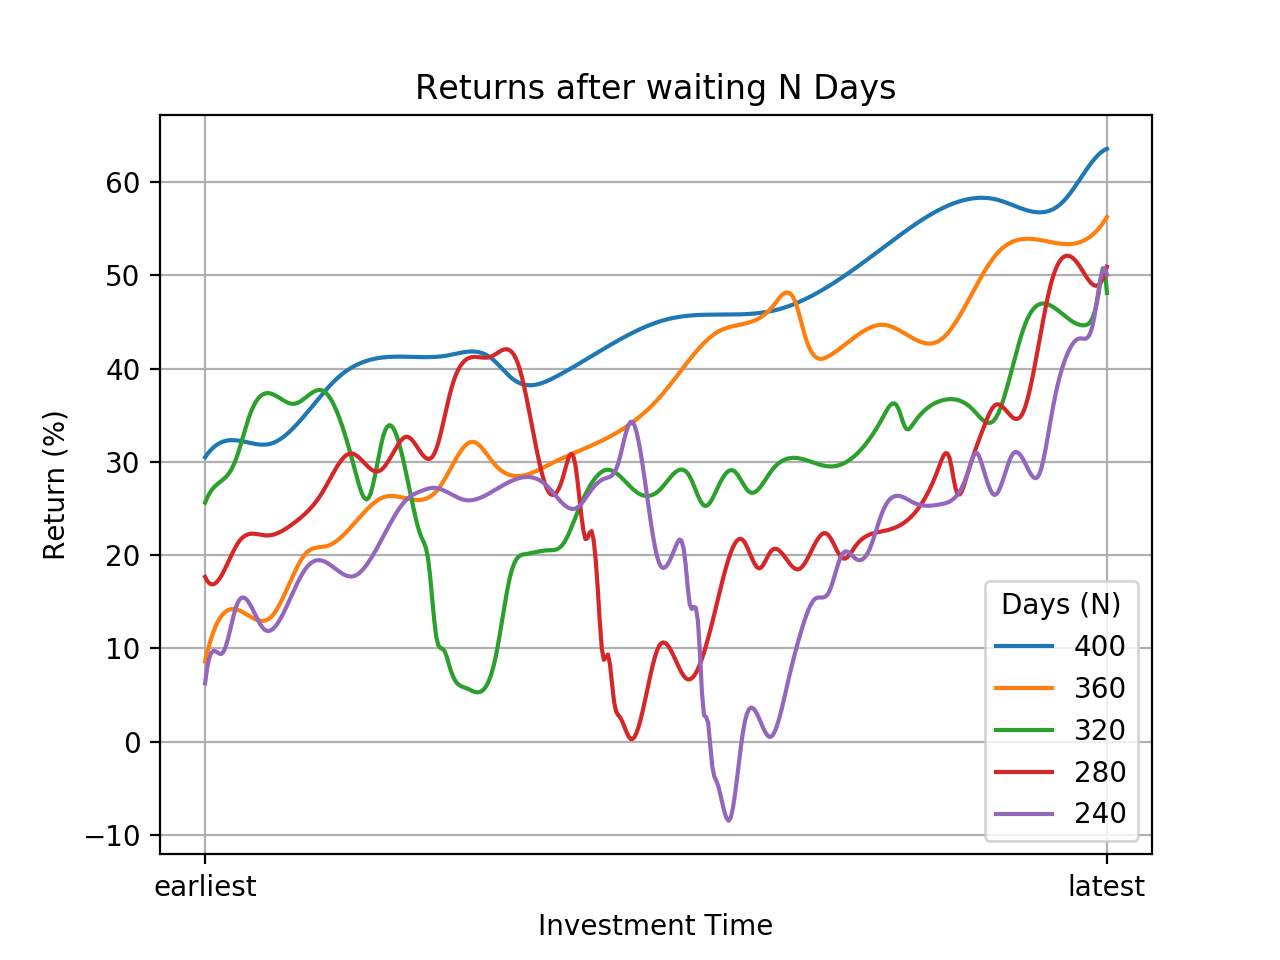

In [24]:
lintvs = [400, 360, 320, 280, 240]
plt.figure()
for intv in  lintvs:
    plt.plot(np.linspace(0,1,span), get_intv(intv, resample=True), label=str(intv))
plt.xticks([0,1], ['earliest', 'latest'])
plt.legend(title='Days (N)')
plt.xlabel('Investment Time')
plt.ylabel('Return (%)')
plt.title('Returns after waiting N Days')
ax = plt.gca()
ax.set_axisbelow(True)
plt.grid(zorder=0)
pass

In [25]:
# plt.savefig('figures/long.png')

In [26]:
intvs = lintvs + sintvs
intvs = intvs[::-1]
len(intvs)

10

<IPython.core.display.Javascript object>


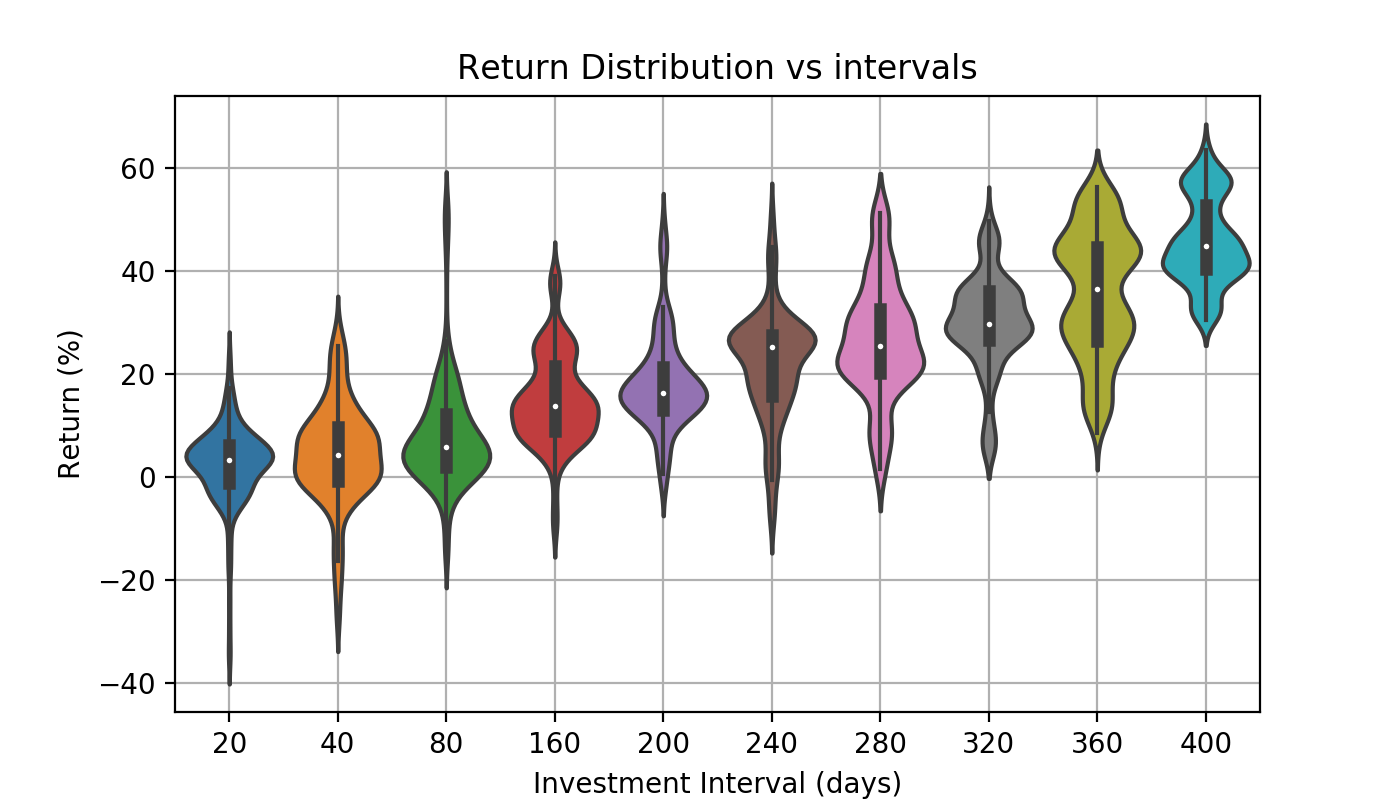

In [27]:
_samples = torch.from_numpy(np.stack([get_intv(intv, resample=True) for intv in intvs])).t()
util.plot_distribs(_samples, figsize=(7,4))

plt.xticks(np.arange(_samples.shape[1]), map(str,intvs))
plt.ylabel('Return (%)')
plt.xlabel('Investment Interval (days)')
plt.title('Return Distribution vs intervals')
ax = plt.gca()
ax.set_axisbelow(True)
plt.grid(zorder=0)
pass

In [28]:
# plt.savefig('figures/distrib.png')

In [29]:
expenses = 0.

for x in T:
    if x.t in etfs:
        expenses += x.w * etfs[x.t].expenses
    elif x.t in funds:
        expenses += x.w * funds[x.t].expenses
print(f'Expenses: {expenses:2.3f}%')

Expenses: 0.192%


In [30]:
sectors = {}

for x in T:
    if x.t in stocks and 'sector' in stocks[x.t]:
        s = {stocks[x.t].sector: 100.}
    elif x.t in funds and 'sectors' in funds[x.t]:
        s = funds[x.t].sectors
    elif x.t in etfs and 'sectors' in etfs[x.t]:
        s = etfs[x.t].sectors
    else:
        print(f'Unknown sector: {x.t}')
        s = {'Unknown': 100.}
        
    for g,w in s.items():
        if g not in sectors:
            sectors[g] = 0.
        sectors[g] += x.w * w
if 'Unknown' not in sectors:
    sectors['Unknown'] = 0.
sectors['Unknown'] += 100. - sum(sectors.values())
print(tabulate(sorted(sectors.items(), key=lambda x: x[1], reverse=True), headers=('Sector', '%')))

Sector                         %
----------------------  --------
Information Technology  19.7154
Bonds                   15
Consumer Discretionary  14.9305
Communication Services  13.5869
Health Care              7.8807
Financials               6.6461
Industrials              5.87365
Commodities              5
Consumer Staples         3.29925
Utilities                2.2822
Materials                2.06935
Real Estate              1.41615
Energy                   1.01655
Unknown                  1.00845
Multi Sector             0.2748


In [31]:
nation2region = {}
for r,ns in SRG.regions.items():
    for n in ns:
        nation2region[n] = r
len(nation2region)

55

In [32]:
nations = {}
regions = {}

for x in T:
    if x.t in stocks and 'nation' in stocks[x.t]:
        s = {stocks[x.t].nation: 100.}
    elif x.t in funds and 'nations' in funds[x.t]:
        s = funds[x.t].nations
    elif x.t in etfs and 'nations' in etfs[x.t]:
        s = etfs[x.t].nations
    else:
        print(f'Unknown nation: {x.t}')
        s = {'Unknown': 100.}
        
    for g,w in s.items():
        if g not in nations:
            nations[g] = 0.
        nations[g] += x.w * w
        if g in nation2region:
            r = nation2region[g]
            if r not in regions:
                regions[r] = 0.
            regions[r] += x.w * w
        else:
            print(f'Not found: {g}')
if 'Unknown' not in regions:
    regions['Unknown'] = 0.
if 'Unknown' not in nations:
    nations['Unknown'] = 0.
    
nations['Unknown'] += 100. - sum(nations.values())
print(tabulate(sorted(nations.items(), key=lambda x: x[1], reverse=True), headers=('Nation', '%')))

Not found: Qatar
Unknown nation: IAU
Not found: Unknown
Nation               %
------------  --------
US            56.9396
China         19.0502
Unknown        6.29475
Japan          5.057
UK             1.5309
Korea          1.4658
Germany        1.3051
France         1.04595
Canada         0.95955
Taiwan         0.81455
Switzerland    0.8077
India          0.465
Brazil         0.4032
Australia      0.38735
Hong Kong      0.36365
Netherlands    0.34965
Sweden         0.25325
Spain          0.25135
Italy          0.2396
Denmark        0.2361
South Africa   0.2271
Russia         0.218
Israel         0.16885
Singapore      0.1654
Saudi Arabia   0.1342
Thailand       0.105
Luxembourg     0.0981
Poland         0.09165
Malaysia       0.0888
Mexico         0.07465
New Zealand    0.073
Indonesia      0.051
Ireland        0.0466
Norway         0.0464
Philippines    0.0408
Austria        0.0406
Qatar          0.0405
Finland        0.0364
Belgium        0.0326
Puerto Rico    0.0001


In [33]:
regions['Unknown'] += 100. - sum(regions.values())
print(tabulate(sorted(regions.items(), key=lambda x: x[1], reverse=True), headers=('Region', '%')))

Region                %
-------------  --------
North America  57.8992
East Asia      27.1104
Unknown         6.33525
West Europe     5.74815
North Europe    0.57215
Oceania         0.55215
Latin America   0.47795
South Asia      0.465
East Europe     0.30965
Middle East     0.30305
Africa          0.2271


In [ ]:
# get current return (from the last N days)
N = 10

In [26]:
for x in tqdm(T):
    x.data = get_data(x.t, hist=N)

C:\Users\anwan\anaconda3\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [27]:
tks = np.array(list(T.select('t')))

In [28]:
w = np.array(list(T.select('w')))
w.sum(), w.shape

(1.0, (53,))

In [29]:
span = min(map(len,T.select('data')))
span

5

In [30]:
close = np.stack(d[-span:] for d in T.select('data'))
close.shape

(53, 5)

In [31]:
out = close[:,-1] - close[:,0]
order = np.argsort(out)[::-1]
print(tabulate(np.stack([tks,out],1)[order], headers=('Company', '%')))

Company             %
---------  ----------
TSLA        8.32015
ACES        5.15792
AMD         5.00731
ICLN        5.00726
SNE         4.91143
PHO         4.03743
SKYY        3.99252
IBB         3.94981
XITK        3.86671
PYPL        3.7841
CIBR        3.74332
AMZN        3.65888
FSMAX       3.44659
FZIPX       2.97143
GOOG        2.9686
FHLC        2.9217
FLGR        2.90381
0700.HK     2.85714
VONG        2.51078
BABA        2.50624
FB          2.3735
FIDU        2.23018
FZROX       1.95556
SOCL        1.8158
XCEM        1.68705
FSPSX       1.59534
MSFT        1.55988
FSGGX       1.36327
VCLT        1.35036
NVDA        1.28891
EWY         1.18544
LQD         1.02715
FNCL        0.775194
FLJP        0.606551
IGOV        0.562124
FIPDX       0.465116
IAU         0.462695
ESPO        0.350166
AGG         0.286509
VCSH        0.217839
IAGG        0.12599
MINT        0.0787092
VGLT        0.0294377
FUAMX       0
SCHO       -0.0193836
KWEB       -0.104759
MCHI       -0.260703
DIS        

In [33]:
out @ w

1.7028775164629721

In [49]:
# date: 7/21 after close
current_raw = '''"Account Name/Number","Symbol","Description","Quantity","Last Price","Last Price Change","Current Value","Today's Gain/Loss Dollar","Today's Gain/Loss Percent","Total Gain/Loss Dollar","Total Gain/Loss Percent","Cost Basis Per Share","Cost Basis Total","Type"
"X85564829","FCASH**","Cash",310.010,$1.00,$0.00,$310.01,n/a,n/a,n/a,n/a,n/a,n/a,"Cash"
"X85564829","ACES","ALPS ETF TR CLEAN ENERGY",33.920,$46.346,+$0.126,$1572.03,+$4.25,+0.27%,-$5.21,-0.33%,$46.50,$1577.25,"Cash"
"X85564829","AGG","ISHARES CORE U.S. AGGREGATE BOND ETF",6.625,$119.210,+$0.13,$789.76,+$0.86,+0.11%,+$1.15,+0.15%,$119.04,$788.62,"Cash"
"X85564829","AMD","ADVANCED MICRO DEVICES INC COM",27.692,$61.385,+$4.385,$1699.87,+$121.42,+7.69%,+$122.60,+7.77%,$56.96,$1577.27,"Cash"
"X85564829","AMZN","AMAZON.COM INC",0.746,$3092.630,-$45.66,$2307.10,-$34.07,-1.45%,-$57.33,-2.42%,$3169.48,$2364.43,"Cash"
"X85564829","ASHR","DBX ETF TR XTRACK HRVST CSI",104.202,$33.725,-$0.265,$3514.21,-$27.62,-0.78%,-$34.68,-0.98%,$34.06,$3548.89,"Cash"
"X85564829","BABA","ALIBABA GROUP HOLDING LTD SPON ADS EACH REP 8 ORD SHS",9.128,$249.900,-$8.00,$2281.08,-$73.03,-3.10%,-$84.82,-3.59%,$259.19,$2365.91,"Cash"
"X85564829","BIDU","BAIDU INC SPON ADS EACH REP 0.1 ORD SHS",6.303,$120.980,-$4.24,$762.53,-$26.73,-3.39%,-$26.09,-3.31%,$125.12,$788.63,"Cash"
"X85564829","CIBR","FIRST TR EXCHANGE TRADED FD II NASDAQ CYB ETF",34.042,$34.760,-$0.03,$1183.29,-$1.03,-0.09%,+$0.34,+0.03%,$34.75,$1182.96,"Cash"
"X85564829","CNYA","ISHARES MSCI CHINA A ETF",75.925,$36.220,-$0.09,$2750.00,-$6.84,-0.25%,-$10.26,-0.37%,$36.35,$2760.26,"Cash"
"X85564829","DIS","DISNEY WALT CO",3.320,$118.190,-$0.43,$392.39,-$1.43,-0.36%,-$1.82,-0.46%,$118.74,$394.21,"Cash"
"X85564829","EMXC","ISHARES MSCI EMR MRK EX CHNA",51.384,$45.925,-$0.065,$2359.81,+$1.53,+0.06%,+$1.53,+0.06%,$45.90,$2358.28,"Cash"
"X85564829","ESPO","VANECK VECTORS ETF TR VIDEO GAMING",21.589,$54.670,-$0.06,$1180.27,-$1.30,-0.11%,-$2.69,-0.23%,$54.79,$1182.96,"Cash"
"X85564829","EWG","ISHARES INC MSCI GERMANY ETF",13.285,$29.585,$0.205,$393.03,$0.00,0.00%,$0.00,0.00%,$29.59,$393.04,"Cash"
"X85564829","EWY","ISHARES MSCI SOUTH KOREA ETF",6.561,$59.730,-$0.37,$391.88,-$2.43,-0.62%,-$2.43,-0.62%,$60.10,$394.32,"Cash"
"X85564829","FB","FACEBOOK INC-CLASS A",1.634,$238.865,-$2.885,$390.30,-$4.72,-1.19%,-$3.78,-0.96%,$241.18,$394.09,"Cash"
"X85564829","FHLC","FIDELITY MSCI HEALTH CARE INDEX ETF",14.954,$53.020,+$0.35,$792.86,+$5.23,+0.66%,+$4.26,+0.54%,$52.74,$788.60,"Cash"
"X85564829","FIDU","FIDELITY MSCI INDL INDEX ETF",10.506,$37.840,+$0.28,$397.54,+$2.94,+0.75%,+$3.26,+0.83%,$37.53,$394.29,"Cash"
"X85564829","FIPDX","FIDELITY INFLAT-PROT BD INDEX FUND",72.888,$10.82,+$0.02,$788.64,+$1.45,+0.19%,$0.00,0.00%,$10.82,$788.65,"Cash"
"X85564829","FLJP","FRANKLIN TEMPLETON ETF TR FTSE JAPAN ETF",47.518,$24.775,-$0.075,$1177.25,-$3.57,-0.30%,-$5.71,-0.48%,$24.90,$1182.97,"Cash"
"X85564829","FNCL","FIDELITY MSCI FINLS INDEX ETF",11.434,$34.335,-$0.195,$392.58,-$2.23,-0.56%,-$1.72,-0.44%,$34.49,$394.31,"Cash"
"X85564829","FSGGX","FIDELITY GLOBAL EX US INDEX FUND",247.807,$12.73,+$0.09,$3154.58,+$22.30,+0.71%,+$0.00,+0.00%,$12.73,$3154.58,"Cash"
"X85564829","FSMAX","FIDELITY EXTENDED MARKET INDEX FUND",37.206,$63.59,+$0.26,$2365.92,+$9.67,+0.41%,-$0.01,0.00%,$63.59,$2365.94,"Cash"
"X85564829","FSPSX","FIDELITY INTERNATL INDEX FUND",68.513,$40.33,+$0.21,$2763.12,+$14.38,+0.52%,+$18.23,+0.66%,$40.06,$2744.90,"Cash"
"X85564829","FUAMX","FID INTER TREASURY BOND INDEX FUND",163.483,$12.06,+$0.01,$1971.60,+$1.63,+0.08%,-$0.01,0.00%,$12.06,$1971.61,"Cash"
"X85564829","FZIPX","FIDELITY ZERO EXTND MARKET INDEX FUND",259.993,$9.10,+$0.09,$2365.93,+$23.39,+1.00%,$0.00,0.00%,$9.10,$2365.94,"Cash"
"X85564829","FZROX","FIDELITY ZERO TOTAL MARKET INDEX",411.491,$11.50,+$0.03,$4732.14,+$12.34,+0.26%,+$2.23,+0.05%,$11.49,$4729.92,"Cash"
"X85564829","GOOG","ALPHABET INC CAP STK CL C",0.504,$1557.140,-$1.28,$784.79,-$0.65,-0.08%,-$3.28,-0.42%,$1563.65,$788.08,"Cash"
"X85564829","IAGG","ISHARES INTL AGGREGATE BOND",14.156,$55.810,+$0.08,$790.04,+$1.13,+0.14%,+$1.43,+0.18%,$55.71,$788.62,"Cash"
"X85564829","IAU","ISHARES GOLD TRUST ISHARES ISIN #US4642851053 SEDOL B0SF3S5",224.104,$17.790,+$0.20,$3986.81,+$44.82,+1.14%,+$43.59,+1.11%,$17.60,$3943.22,"Cash"
"X85564829","IBB","ISHARES TR NASDAQ BIOTECH",11.023,$141.960,-$0.50,$1564.82,-$5.52,-0.35%,-$12.34,-0.78%,$143.08,$1577.17,"Cash"
"X85564829","ICLN","ISHARES TR GL CLEAN ENE ETF",54.258,$14.635,+$0.095,$794.06,+$5.15,+0.65%,+$5.43,+0.69%,$14.54,$788.64,"Cash"
"X85564829","IGOV","ISHARES TR INTL TREA BD ETF",15.053,$52.490,+$0.21,$790.13,+$3.16,+0.40%,+$1.50,+0.19%,$52.39,$788.63,"Cash"
"X85564829","KWEB","KRANESHARES TR CSI CHINA INTERNET ETF",23.107,$66.043,-$1.947,$1526.06,-$44.99,-2.86%,-$51.22,-3.25%,$68.26,$1577.28,"Cash"
"X85564829","LQD","ISHARES IBOXX INVESTMENT GRADE CORPORATE BOND ETF",5.718,$138.285,+$0.405,$790.71,+$2.31,+0.29%,+$2.10,+0.27%,$137.92,$788.61,"Cash"
"X85564829","MCHI","ISHARES TR MSCI CHINA ETF",10.735,$71.855,-$1.395,$771.36,-$14.98,-1.90%,-$17.22,-2.18%,$73.46,$788.58,"Cash"
"X85564829","MINT","PIMCO ETF TRUST ENHANCED SHORT MATURITY ACTIVE ETF USD",3.875,$101.770,+$0.02,$394.35,+$0.07,+0.02%,+$0.09,+0.02%,$101.75,$394.27,"Cash"
"X85564829","MSFT","MICROSOFT CORP",11.698,$209.830,+$1.08,$2454.59,+$12.63,+0.52%,+$2187.29,+818.29%,$22.85,$267.30,"Cash"
"X85564829","NFLX","NETFLIX COM INC COM",0.802,$488.900,-$1.20,$392.09,-$0.97,-0.24%,-$1.78,-0.45%,$491.12,$393.88,"Cash"
"X85564829","NTDOY","NINTENDO CO LTD ADR(8 CNV INTO 1 ORD)NPV",14.000,$55.47,-$0.02,$776.58,-$0.28,-0.04%,-$1.75,-0.22%,$55.60,$778.33,"Cash"
"X85564829","NVDA","NVIDIA CORPORATION COM",3.812,$416.200,+$3.06,$1586.55,+$11.66,+0.74%,+$9.54,+0.61%,$413.70,$1577.01,"Cash"
"X85564829","PHO","INVESCO EXCHANGE TRADED FD TR WATER RES ETF",20.157,$39.475,+$0.315,$795.69,+$6.34,+0.80%,+$7.06,+0.89%,$39.12,$788.64,"Cash"
"X85564829","PYPL","PAYPAL HLDGS INC COM",4.507,$177.196,+$1.616,$798.62,+$7.28,+0.92%,+$10.03,+1.27%,$174.97,$788.59,"Cash"
"X85564829","SCHO","SCHWAB STRATEGIC TR SHORT-TERM US TREASURY ETF",30.576,$51.590,-$0.01,$1577.41,-$0.31,-0.02%,+$0.16,+0.01%,$51.58,$1577.26,"Cash"
"X85564829","SKYY","FIRST TRUST CLOUD COMPUTING ETF",10.223,$77.270,+$0.02,$789.93,+$0.20,+0.03%,+$1.33,+0.17%,$77.14,$788.60,"Cash"
"X85564829","SNE","SONY CORP SPON ADR EACH REPR 1 ORD",5.097,$77.191,-$0.119,$393.44,-$0.61,-0.15%,-$0.87,-0.22%,$77.36,$394.31,"Cash"
"X85564829","SOCL","GLOBAL X FDS GLOBAL X SOCIAL MEDIA ETF USD",16.971,$45.950,-$0.47,$779.81,-$7.98,-1.01%,-$8.82,-1.12%,$46.47,$788.64,"Cash"
"X85564829","TCEHY","TENCENT HOLDINGS LIMITED UNSPON ADR",33.000,$69.6,-$1.89,$2296.80,-$62.37,-2.64%,-$75.41,-3.18%,$71.89,$2372.21,"Cash"
"X85564829","TSLA","TESLA INC COM",1.485,$1582.860,+$14.50,$2350.54,+$21.53,+0.92%,-$3.89,-0.17%,$1585.48,$2354.44,"Cash"
"X85564829","VCLT","VANGUARD SCOTTSDALE FUNDS LONG-TERM CORP BOND IDX FUND",14.142,$111.810,+$0.54,$1581.21,+$7.63,+0.49%,+$4.03,+0.26%,$111.53,$1577.19,"Cash"
"X85564829","VCSH","VANGUARD SCOTTSDALE FDS VANGUARD SHORT-TERM CORPORATE BD IND",9.514,$82.870,-$0.02,$788.42,-$0.20,-0.02%,-$0.19,-0.02%,$82.89,$788.62,"Cash"
"X85564829","VGK","VANGUARD INTL EQUITY INDEX FDS FTSE EUROPE ETF",14.614,$53.768,$0.178,$785.76,-$0.30,-0.04%,-$0.30,-0.04%,$53.79,$786.07,"Cash"
"X85564829","VGLT","VANGUARD SCOTTSDALE FDS LONG TERM TREAS",15.439,$102.560,+$0.51,$1583.42,+$7.87,+0.50%,+$6.17,+0.39%,$102.16,$1577.25,"Cash"
"X85564829","VONG","VANGUARD SCOTTSDALE FDS VANGUARD RUSSELL",11.215,$209.900,+$0.44,$2354.02,+$4.93,+0.21%,-$11.79,-0.50%,$210.95,$2365.82,"Cash"
"X85564829","XITK","SPDR SER TR FACTST INV ETF",10.097,$155.640,-$0.38,$1571.49,-$3.84,-0.24%,-$5.75,-0.36%,$156.21,$1577.25,"Cash"'''

raw = [c.split(',') for c in current_raw.split('\n')]
data = np.array(raw)

data = data[:,[1,6,4,3,2,9]]
headers, data = data[0], data[1:]

print(tabulate(data, headers=headers))

"Symbol"    "Current Value"    "Last Price"      "Quantity"  "Description"                                                   "Total Gain/Loss Dollar"
----------  -----------------  --------------  ------------  --------------------------------------------------------------  --------------------------
"FCASH**"   $310.01            $1.00                310.01   "Cash"                                                          n/a
"ACES"      $1572.03           $46.346               33.92   "ALPS ETF TR CLEAN ENERGY"                                      -$5.21
"AGG"       $789.76            $119.210               6.625  "ISHARES CORE U.S. AGGREGATE BOND ETF"                          +$1.15
"AMD"       $1699.87           $61.385               27.692  "ADVANCED MICRO DEVICES INC COM"                                +$122.60
"AMZN"      $2307.10           $3092.630              0.746  "AMAZON.COM INC"                                                -$57.33
"ASHR"      $3514.21           $33.725

In [65]:
titles = [t[1:-1] for t in data[:,0]]
repl = {'TCEHY':'0700.HK'}
titles = [repl[t] if t in repl else t for t in titles]
value = [float(c[1:]) for c in data[:,1]]
value[0] += -10
# titles, value

In [66]:
cash_name = 'FCASH**'
keep_cash = 500.
print(f'Will not invest {keep_cash}')

Will not invest 500.0


In [67]:
current = {t:v for t,v in zip(titles,value) if t != cash_name}

In [68]:
capital = sum(value) - keep_cash

In [69]:
goal = {x.t:x.w*capital for x in T}
len(goal)

54

In [70]:
# errors: XCEM,FLGR

In [71]:
delta = {}
for t,g in goal.items():
    if t in current:
        g -= current[t]
    delta[t] = g

In [72]:
orders = sorted(delta.items(), key=lambda x: (np.sign(x[1]), -np.abs(x[1]), x[0]))
print(tabulate(orders, headers=('Name', 'Amount')))

Name        Amount
-------  ---------
AMD      -129.486
MSFT      -99.0134
IAU       -60.849
FZROX     -20.9868
NVDA      -16.1656
FSPSX     -14.9473
FSGGX     -13.8112
PYPL      -13.4278
VGLT      -13.0356
VCLT      -10.8256
PHO       -10.4978
FZIPX     -10.3534
FSMAX     -10.3434
ICLN       -8.8678
FUAMX      -8.6195
FHLC       -7.6678
SCHO       -7.0256
LQD        -5.5178
CIBR       -5.5017
FIDU       -4.9439
IGOV       -4.9378
IAGG       -4.8478
SKYY       -4.7378
AGG        -4.5678
EMXC       -4.2334
FIPDX      -3.4478
VCSH       -3.2278
ESPO       -2.4817
CNYA       -1.8273
MINT       -1.7539
ACES       -1.6456
XITK       -1.1056
SNE        -0.8439
VGK        -0.5678
EWG        -0.4339
BABA       74.4966
0700.HK    58.7766
AMZN       48.4766
KWEB       44.3244
BIDU       22.6622
ASHR       19.1549
MCHI       13.8322
NTDOY       8.6122
IBB         5.5644
SOCL        5.3822
TSLA        5.0366
FB          2.2961
VONG        1.5566
EWY         0.7161
FLJP        0.5383
NFLX        0.

In [15]:
for a in T:
    print(a.t, a.w*total_value)

MSFT 2391.5922
AMZN 2391.5922
TSLA 2391.5922
AMD 1594.3948
NVDA 1594.3948
BABA 2391.5922
0700.HK 2391.5922
GOOG 797.1974
BIDU 797.1974
SNE 398.5987
NTDOY 797.1974
FB 398.5987
PYPL 797.1974
NFLX 398.5987
DIS 398.5987
FZROX 4783.1844
FSMAX 2391.5922
FZIPX 2391.5922
VONG 2391.5922
XITK 1594.3948
SOCL 797.1974
ESPO 1195.7961
CIBR 1195.7961
SKYY 797.1974
IBB 1594.3948
FHLC 797.1974
PHO 797.1974
ACES 1594.3948
ICLN 797.1974
FIDU 398.5987
FNCL 398.5987
ASHR 3587.3883
CNYA 2790.1909000000005
KWEB 1594.3948
MCHI 797.1974
FSPSX 2790.1909000000005
FLGR 1195.7961
FLJP 1195.7961
EWY 398.5987
FSGGX 3188.7896
XCEM 2391.5922
FIPDX 797.1974
VGLT 1594.3948
FUAMX 1992.9935000000003
SCHO 1594.3948
MINT 398.5987
IGOV 797.1974
VCLT 1594.3948
AGG 797.1974
VCSH 797.1974
LQD 797.1974
IAGG 797.1974
IAU 3985.9870000000005


In [34]:
# import re

In [35]:
changes = {
    'Korea (South)': 'Korea',
    'South Korea': 'Korea',
    'United Kingdom': 'UK',
    'United States': 'US',
}

In [36]:
raw = '''Taiwan	24.39%
South Korea	17.96%
India	13.73%
Brazil	9.90%
Russia	6.66%
South Africa	5.71%
Thailand	5.45%
Malaysia	3.26%
Indonesia	3.24%
Philippines	1.94%
Poland	1.52%
Mexico	1.37%
Chile	1.33%
United States	0.99%
United Kingdom	0.59%
Turkey	0.42%
Hong Kong	0.36%
France	0.35%'''

info = dict(line.split('\t') for line in raw.split('\n'))
info = {(changes[k] if k in changes else k):float(v[:-1]) for k,v in info.items()}
print(str(info) + ',')

{'Taiwan': 24.39, 'Korea': 17.96, 'India': 13.73, 'Brazil': 9.9, 'Russia': 6.66, 'South Africa': 5.71, 'Thailand': 5.45, 'Malaysia': 3.26, 'Indonesia': 3.24, 'Philippines': 1.94, 'Poland': 1.52, 'Mexico': 1.37, 'Chile': 1.33, 'US': 0.99, 'UK': 0.59, 'Turkey': 0.42, 'Hong Kong': 0.36, 'France': 0.35},


In [37]:
raw[0].find

<function str.find>

In [38]:
raw = '''Information Technology	20.95%	21.04%	
0
110
Health Care	15.94%	16.01%	
0
110
Financials	14.51%	14.57%	
0
110
Consumer Discretionary	12.70%	12.75%	
0
110
Industrials	12.41%	12.46%	
0
110
Real Estate	7.63%	7.67%	
0
110
Communication Services	4.83%	4.87%	
0
110
Materials	3.74%	3.75%	
0
110
Consumer Staples	2.76%	2.77%	
0
110
Utilities	2.57%	2.58%	
0
110
Energy	1.52%	1.53%	
0
110
Multi Sector	0.44%	--	
0
110
Other	0.00%	0.00%'''.split('\n')

info = (line.split('\t')[:2] for line in raw if len(line) > 4)

content = {}
for n,w in info:
    content[n] = float(w[:-1])
print(str(content) + ',')


{'Information Technology': 20.95, 'Health Care': 15.94, 'Financials': 14.51, 'Consumer Discretionary': 12.7, 'Industrials': 12.41, 'Real Estate': 7.63, 'Communication Services': 4.83, 'Materials': 3.74, 'Consumer Staples': 2.76, 'Utilities': 2.57, 'Energy': 1.52, 'Multi Sector': 0.44, 'Other': 0.0},


In [39]:
list(content.keys())

['Information Technology',
 'Health Care',
 'Financials',
 'Consumer Discretionary',
 'Industrials',
 'Real Estate',
 'Communication Services',
 'Materials',
 'Consumer Staples',
 'Utilities',
 'Energy',
 'Multi Sector',
 'Other']

In [40]:
# raw = '''Japan25.90%United Kingdom14.25%France10.43%Switzerland10.12%Germany8.63%Australia6.37%Netherlands4.05%Hong Kong3.28%Sweden2.82%Spain2.41%Denmark2.25%United States2.13%Italy2.04%Singapore1.11%Finland1.04%
# '''
# raw = raw.split('%')[:-1]

# content = {}
# for l in raw:
#     i = re.search(r"\d", l).start()
#     c = l[:i]
#     if c in changes:
#         c = changes[c]
#     content[c] = float(l[i:])
# print(str(content) + ',')

In [41]:
sectors = {
    'Information Technology': 'tech',
    'Health Care': 'healthcare',
    'Financials': 'financials',
    'Consumer Discretionary': 'service',
    'Industrials': 'industrials',
    'Consumer Staples': 'goods',
    'Real Estate': 'real estate',
}